
* Module Name - 7082CEM Big Data Management and Visualization
*Name - Sonali Agarkar \
*Student ID - 10612501



* Importing Basic Libraries


In [203]:
import pandas as pd
import numpy as np
import seaborn as sns;sns.set(style="white")
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.simplefilter("ignore")


* Creating virtual Spark environment


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
import findspark
findspark.init()

* Kaggle API:Reading dataset from kaggle
Here I have directly picking dataset from kaggle website. To access the dataset, pl upload kaggle.json  (token) file  under the Files option here in order to run this code. 

In [205]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"


!kaggle datasets download -d khsamaha/aviation-accident-database-synopses



import zipfile
with zipfile.ZipFile("/content/aviation-accident-database-synopses.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")


aviation-accident-database-synopses.zip: Skipping, found more recently modified local copy (use --force to force download)



### * Pyspark Code 


* Loading Orignal Dataset in pyspark

In [206]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

df = spark.read.csv('/content/AviationData.csv', inferSchema=True, header =True)

print("The dataset contains {} rows and {} columns.".format(df.count(), len(df.columns)))
df.show(5)

The dataset contains 85976 rows and 31 columns.
+-----------+------------------+---------------+----------+------------------+-------------+---------+----------+------------+------------+---------------+---------------+-----------------+-------------------+--------+-------+-------------+-----------------+-----------+---------------+--------+-----------------+--------------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+-------------+----------------+
|   Event.Id|Investigation.Type|Accident.Number|Event.Date|          LOCATION|      Country| Latitude| Longitude|Airport.Code|Airport.Name|Injury.Severity|Aircraft.damage|Aircraft.Category|Registration.Number|    Make|  Model|Amateur.Built|Number.of.Engines|Engine.Type|FAR.Description|Schedule|Purpose.of.flight|         Air.carrier|Total.Fatal.Injuries|Total.Serious.Injuries|Total.Minor.Injuries|Total.Uninjured|Weather.Condition|Broad.phase.of.flight|Report.Sta

In [207]:
df.toPandas().to_csv('box.csv') #saving intermediate dataframe for analysis purpose

In [208]:
df.printSchema() #printing column names and type

root
 |-- Event.Id: string (nullable = true)
 |-- Investigation.Type: string (nullable = true)
 |-- Accident.Number: string (nullable = true)
 |-- Event.Date: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Airport.Code: string (nullable = true)
 |-- Airport.Name: string (nullable = true)
 |-- Injury.Severity: string (nullable = true)
 |-- Aircraft.damage: string (nullable = true)
 |-- Aircraft.Category: string (nullable = true)
 |-- Registration.Number: string (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Amateur.Built: string (nullable = true)
 |-- Number.of.Engines: integer (nullable = true)
 |-- Engine.Type: string (nullable = true)
 |-- FAR.Description: string (nullable = true)
 |-- Schedule: string (nullable = true)
 |-- Purpose.of.flight: string (nullable = true)
 |-- Air.carrier: string (n

* Removing Irrelevant columns

In [209]:
columns_to_drop = ['Event.Id','Accident.Number','Airport.Code','Airport.Name','Location',
                   'Injury.Severity','Registration.Number','FAR.Description','Air.Carrier',
                   'Report.Status','Publication.Date','Number.of.Engines',
                   'Latitude','Longitude','Aircraft.Category','Schedule']
df = df.drop(*columns_to_drop)

* Renaming the column names

In [210]:
from pyspark.sql import functions as f
df = df.select([f.col("`{0}`".format(c)).alias(c.replace('.', ' ')) for c in df.columns])

* Replacing missing or nan values

In [211]:

df=df.na.fill(value =0, subset= ['Total Fatal Injuries', 'Total Serious Injuries', 'Total Minor Injuries',"Total Uninjured"])
df=df.na.fill("UNK",['Weather Condition'])
df=df.na.fill("Unknown",["Aircraft damage", 'Make','Engine Type','Broad phase of flight'])
df=df.na.fill("No",['Amateur Built'])
df =df.na.fill("Unknown",["Make"])
df=df.replace('Unk',"UNK")


In [212]:
print("After removing irreleveant features the dataset contains {} rows and {} columns.".format(df.count(), len(df.columns)))
df.show(5)

After removing irreleveant features the dataset contains 85976 rows and 15 columns.
+------------------+----------+-------------+---------------+--------+-------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+
|Investigation Type|Event Date|      Country|Aircraft damage|    Make|  Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|
+------------------+----------+-------------+---------------+--------+-------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+
|          Accident|2021-02-16|United States|    Substantial|Velocity|  Vtwin|           No|    Unknown|            Ferry|                   2|                     0|                  

In [213]:
df.printSchema()

root
 |-- Investigation Type: string (nullable = true)
 |-- Event Date: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Aircraft damage: string (nullable = false)
 |-- Make: string (nullable = false)
 |-- Model: string (nullable = true)
 |-- Amateur Built: string (nullable = false)
 |-- Engine Type: string (nullable = false)
 |-- Purpose of flight: string (nullable = true)
 |-- Total Fatal Injuries: integer (nullable = true)
 |-- Total Serious Injuries: integer (nullable = true)
 |-- Total Minor Injuries: integer (nullable = true)
 |-- Total Uninjured: integer (nullable = true)
 |-- Weather Condition: string (nullable = false)
 |-- Broad phase of flight: string (nullable = false)



* __Datatype Check__

In [214]:
display(df)

DataFrame[Investigation Type: string, Event Date: string, Country: string, Aircraft damage: string, Make: string, Model: string, Amateur Built: string, Engine Type: string, Purpose of flight: string, Total Fatal Injuries: int, Total Serious Injuries: int, Total Minor Injuries: int, Total Uninjured: int, Weather Condition: string, Broad phase of flight: string]

In [215]:
df = df[df['Country']=='United States']

In [216]:
print("New dataframe contains  {} rows and {} columns.".format(df.count(), len(df.columns)))
df.show(5)

New dataframe contains  80132 rows and 15 columns.
+------------------+----------+-------------+---------------+--------+-------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+
|Investigation Type|Event Date|      Country|Aircraft damage|    Make|  Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|
+------------------+----------+-------------+---------------+--------+-------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+
|          Accident|2021-02-16|United States|    Substantial|Velocity|  Vtwin|           No|    Unknown|            Ferry|                   2|                     0|                   0|              0|              

In [217]:
df = df.dropna()
print("New dataframe contains  {} rows and {} columns.".format(df.count(), len(df.columns)))
df.show(5)


New dataframe contains  77718 rows and 15 columns.
+------------------+----------+-------------+---------------+--------+-------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+
|Investigation Type|Event Date|      Country|Aircraft damage|    Make|  Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|
+------------------+----------+-------------+---------------+--------+-------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+
|          Accident|2021-02-16|United States|    Substantial|Velocity|  Vtwin|           No|    Unknown|            Ferry|                   2|                     0|                   0|              0|              

In [218]:
df.printSchema()

root
 |-- Investigation Type: string (nullable = true)
 |-- Event Date: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Aircraft damage: string (nullable = false)
 |-- Make: string (nullable = false)
 |-- Model: string (nullable = true)
 |-- Amateur Built: string (nullable = false)
 |-- Engine Type: string (nullable = false)
 |-- Purpose of flight: string (nullable = true)
 |-- Total Fatal Injuries: integer (nullable = true)
 |-- Total Serious Injuries: integer (nullable = true)
 |-- Total Minor Injuries: integer (nullable = true)
 |-- Total Uninjured: integer (nullable = true)
 |-- Weather Condition: string (nullable = false)
 |-- Broad phase of flight: string (nullable = false)



* __Descriptive Statistics:__

In [219]:
from pyspark.sql.functions import split, desc
split_col = split(df["Event Date"], '-')
df = df.withColumn("Year", split_col.getItem(0))

df = df.filter(df.Year >=1982)
df = df.filter(df.Year <=2020)
df.show(5)

+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+
|Investigation Type|Event Date|      Country|Aircraft damage|                Make|        Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|Year|
+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+
|          Accident|2020-12-31|United States|    Substantial|              Cessna|         172R|           No|    Unknown|    Instructional|                   0|                     0|               

In [220]:
df.toPandas().to_csv("box2") #Saving intermediate results into csv file for future use

In [221]:
from pyspark.sql.functions import col
df.select(col("Total Fatal Injuries"), col("Total Serious Injuries"), col("Total Minor Injuries"), col("Total Uninjured")).describe().show()

+-------+--------------------+----------------------+--------------------+------------------+
|summary|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|   Total Uninjured|
+-------+--------------------+----------------------+--------------------+------------------+
|  count|               77653|                 77653|               77653|             77653|
|   mean|  0.3637464103125443|   0.19247163663992375|  0.3071613459879206| 2.854274786550423|
| stddev|   2.052621311486489|    0.7620604246043805|  1.2149351520042764|18.037379903525927|
|    min|                   0|                     0|                   0|                 0|
|    max|                 230|                    81|                 125|               699|
+-------+--------------------+----------------------+--------------------+------------------+



In [222]:
df = df.withColumn("Total Injuries", df["Total Fatal Injuries"] + df["Total Serious Injuries"] + df["Total Minor Injuries"])
df.show(5)


+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+
|Investigation Type|Event Date|      Country|Aircraft damage|                Make|        Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|Year|Total Injuries|
+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+
|          Accident|2020-12-31|United States|    Substantial|              Cessna|         172R|           No|    Unknown|    Instructional|              

* __Unique class count:__

In [223]:
cols = ["Investigation Type", "Aircraft damage", "Amateur Built", "Weather Condition", "Broad phase of flight"]

for i in cols:
  print("{} have {} unique values:" .format(i, df.select(i).distinct().count()))
  df.groupBy(i).count().show(df.select(i).distinct().count())
  print()


Investigation Type have 2 unique values:
+------------------+-----+
|Investigation Type|count|
+------------------+-----+
|          Incident| 1807|
|          Accident|75846|
+------------------+-----+


Aircraft damage have 4 unique values:
+---------------+-----+
|Aircraft damage|count|
+---------------+-----+
|          Minor| 1768|
|        Unknown| 1398|
|      Destroyed|15942|
|    Substantial|58545|
+---------------+-----+


Amateur Built have 2 unique values:
+-------------+-----+
|Amateur Built|count|
+-------------+-----+
|           No|69592|
|          Yes| 8061|
+-------------+-----+


Weather Condition have 3 unique values:
+-----------------+-----+
|Weather Condition|count|
+-----------------+-----+
|              IMC| 5212|
|              UNK|  979|
|              VMC|71462|
+-----------------+-----+


Broad phase of flight have 12 unique values:
+---------------------+-----+
|Broad phase of flight|count|
+---------------------+-----+
|               Cruise|10484|
|   

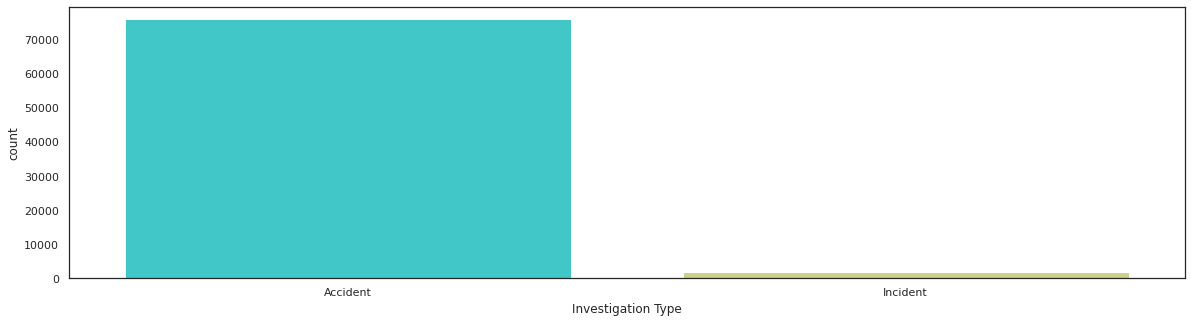

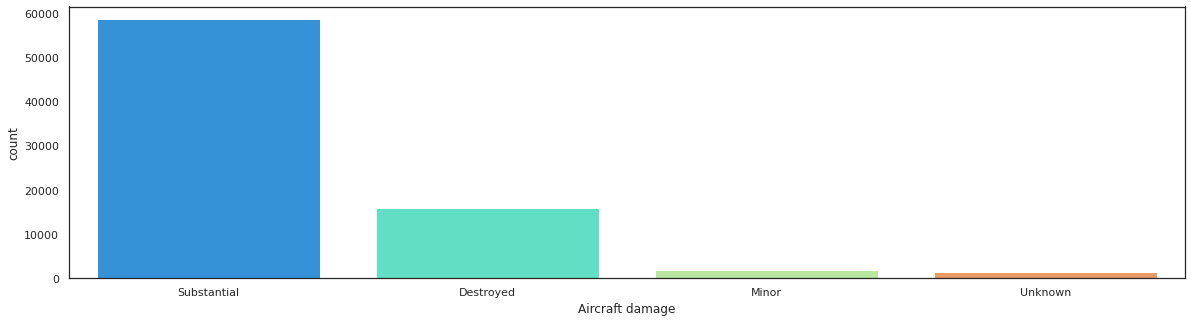

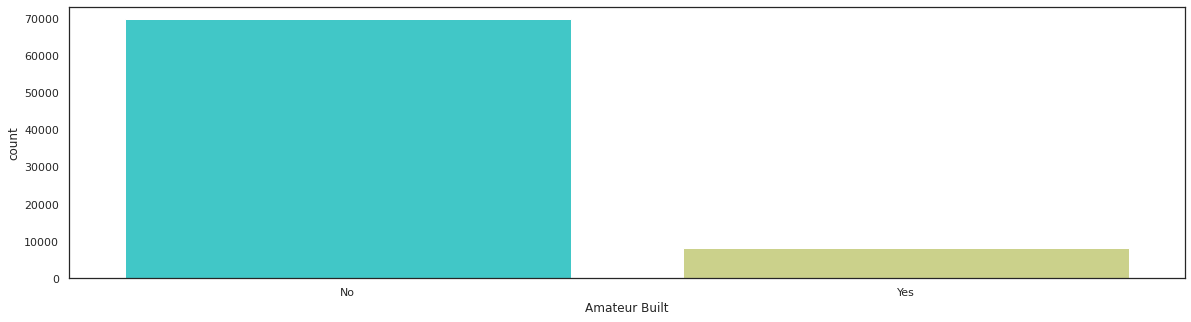

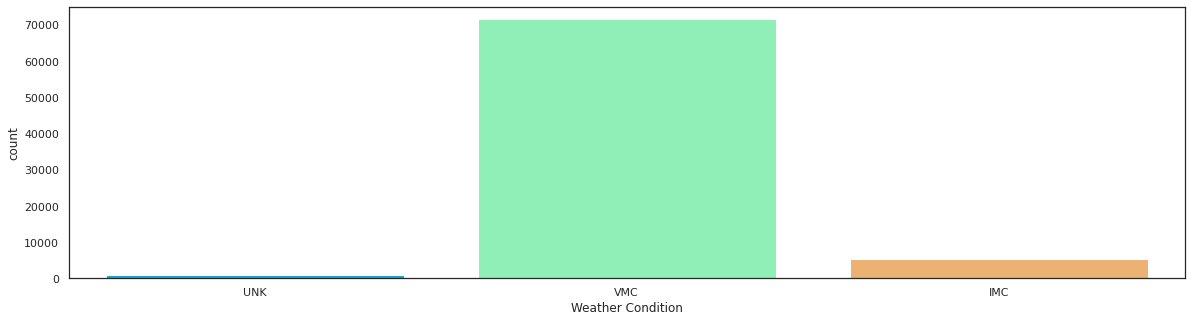

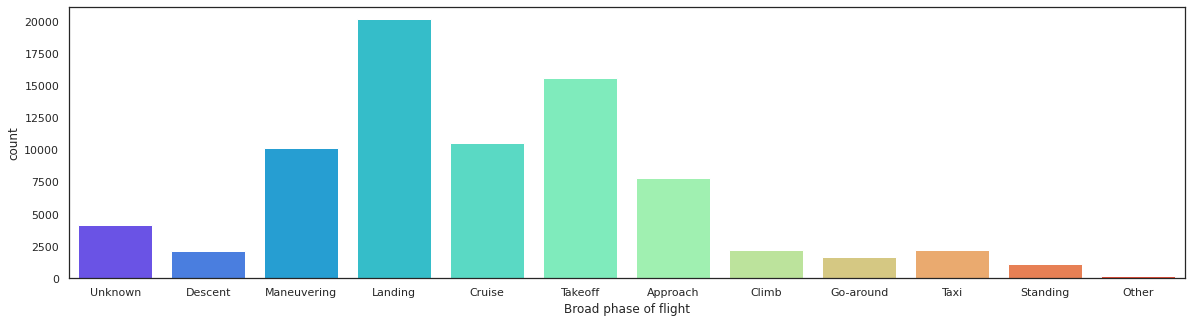

In [224]:
data = df.toPandas()
for i in cols:
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 5)
  sns.countplot(data[i], palette="rainbow")

* __Total Fatal Injuries, Total Serious Injuries, Total Minor Injuries, Total Uninjured__

In [225]:
from pyspark.sql.functions import sum, count

by_year = df.groupBy("Year").agg(sum("Total Fatal Injuries").alias("Total Fatal Injuries"), 
                              sum("Total Serious Injuries").alias("Total Serious Injuries"),
                              sum("Total Minor Injuries").alias("Total Minor Injuries"),
                              sum("Total Uninjured").alias("Total Uninjured"))

by_year = by_year.sort(desc("Year"))
by_year = by_year.withColumn("Year", by_year["Year"].cast('int'))
by_year.show(by_year.select("Year").distinct().count())


+----+--------------------+----------------------+--------------------+---------------+
|Year|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|
+----+--------------------+----------------------+--------------------+---------------+
|2020|                 315|                   180|                 218|            936|
|2019|                 382|                   224|                 326|           1337|
|2018|                 366|                   231|                 340|           1353|
|2017|                 318|                   206|                 325|           1266|
|2016|                 374|                   194|                 356|           1426|
|2015|                 375|                   256|                 320|           1300|
|2014|                 385|                   239|                 365|           1423|
|2013|                 359|                   217|                 378|           1329|
|2012|                 402|     

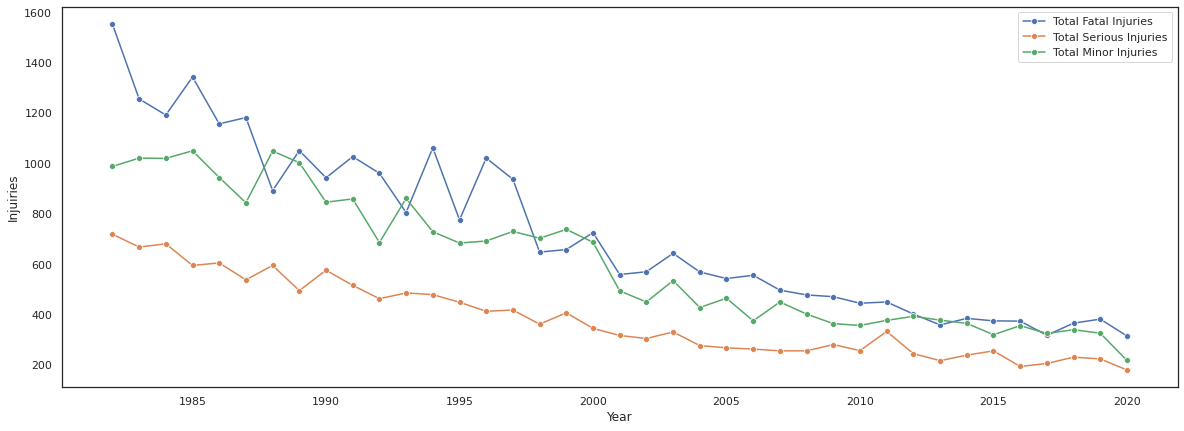

In [226]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
by_year= by_year.toPandas()



sns.lineplot(data=by_year, x="Year", y="Total Fatal Injuries",  marker="o", label="Total Fatal Injuries")
sns.lineplot(data=by_year, x="Year", y="Total Serious Injuries",  marker="o", label="Total Serious Injuries")
sns.lineplot(data=by_year, x="Year", y="Total Minor Injuries",  marker="o", label="Total Minor Injuries")

plt.ylabel("Injuiries")
plt.legend()
plt.show()


In [227]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

def correlation_matrix(df, corr_columns, method="pearson"):
    df = df.dropna()
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    result=result.reshape(-1, len(corr_columns))
    res = pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns)
    res["Variables"] =corr_columns
    res = spark.createDataFrame(res)
    return(res.show())

col = ["Total Fatal Injuries", "Total Serious Injuries", "Total Minor Injuries"]
correlation_matrix(df, col)

+--------------------+----------------------+--------------------+--------------------+
|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|           Variables|
+--------------------+----------------------+--------------------+--------------------+
|                 1.0|   0.20714165886817426| 0.08580445386932783|Total Fatal Injuries|
| 0.20714165886817426|                   1.0|  0.3256326189028076|Total Serious Inj...|
| 0.08580445386932783|    0.3256326189028076|                 1.0|Total Minor Injuries|
+--------------------+----------------------+--------------------+--------------------+



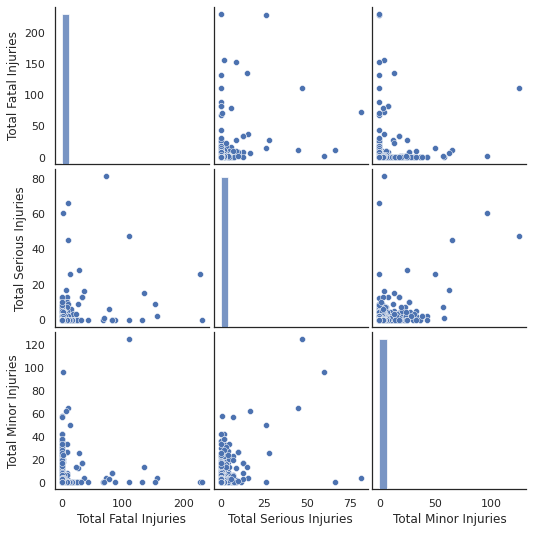

In [228]:
sns.pairplot(data[col])

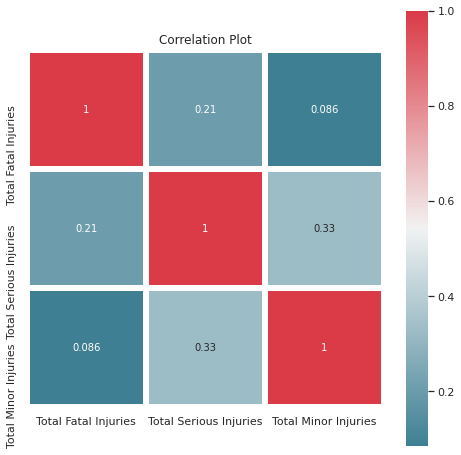

In [229]:
fig, ax =plt.subplots(figsize=(8, 8))
plt.title("Correlation Plot")
sns.heatmap(data[col].corr(), mask=np.zeros_like(data[col].corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True,linewidths=5)
plt.show()

* __Total Injuries v/s Total Uninjured:__

In [230]:
col = ["Total Injuries", "Total Uninjured"]
correlation_matrix(df, col)

+-------------------+-------------------+---------------+
|     Total Injuries|    Total Uninjured|      Variables|
+-------------------+-------------------+---------------+
|                1.0|0.05259356297731778| Total Injuries|
|0.05259356297731778|                1.0|Total Uninjured|
+-------------------+-------------------+---------------+



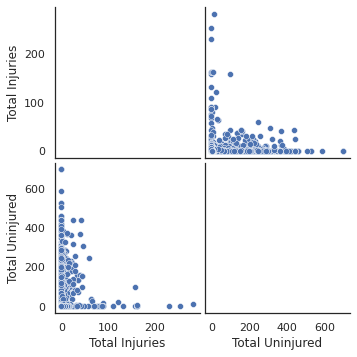

In [231]:
sns.pairplot(data[col])

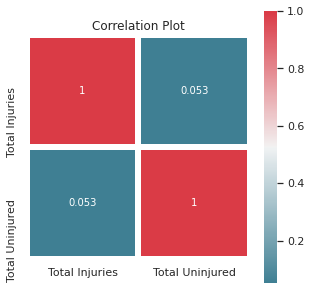

In [232]:
fig, ax =plt.subplots(figsize=(5, 5))
plt.title("Correlation Plot")
sns.heatmap(data[col].corr(), mask=np.zeros_like(data[col].corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True,linewidths=5)
plt.show()

* __Year-wise Total Injured and Total Uninjured:__

In [233]:
year = df.where(f.col("Investigation Type").isin(["Accident"]))

year = year.groupBy("Year").agg(sum("Total Injuries").alias("Total Injuries"), 
                              sum("Total Uninjured").alias("Total Uninjured")
                              )
year = year.sort(desc("Year"))
year = year.withColumn("Year", year["Year"].cast('int'))
year.show(year.select("Year").distinct().count())

+----+--------------+---------------+
|Year|Total Injuries|Total Uninjured|
+----+--------------+---------------+
|2020|           713|            931|
|2019|           932|           1326|
|2018|           937|           1349|
|2017|           849|           1256|
|2016|           924|           1407|
|2015|           949|           1254|
|2014|           989|           1382|
|2013|           951|           1282|
|2012|          1040|           1591|
|2011|          1160|           1494|
|2010|          1059|           1479|
|2009|          1115|           1446|
|2008|          1136|           1727|
|2007|          1202|           1770|
|2006|          1187|           1617|
|2005|          1276|           1770|
|2004|          1273|           1963|
|2003|          1509|           1722|
|2002|          1325|           1815|
|2001|          1370|           1869|
|2000|          1746|           5898|
|1999|          1799|           6738|
|1998|          1696|           6034|
|1997|      

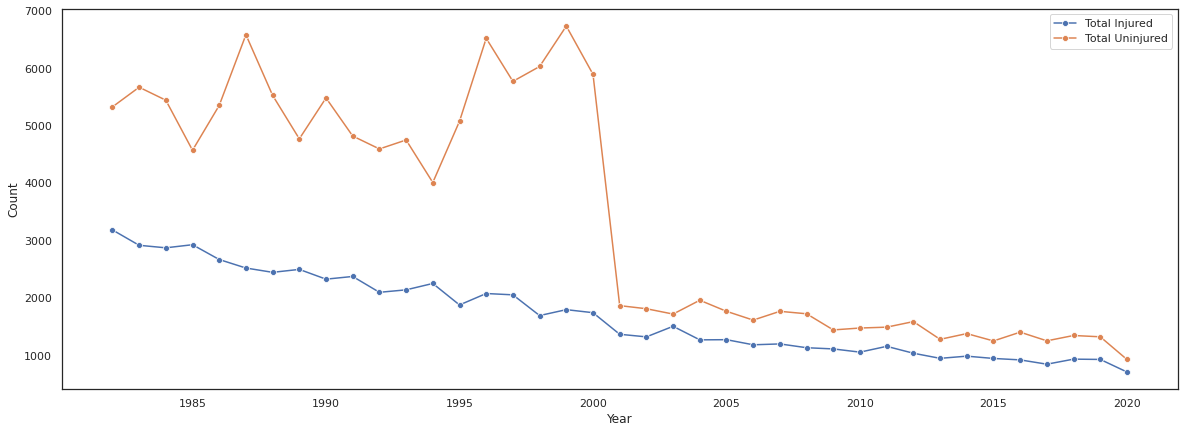

In [234]:
years = year.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
sns.lineplot(data=years, x="Year", y="Total Injuries",  marker="o", label="Total Injured")
sns.lineplot(data=years, x="Year", y="Total Uninjured",  marker="o",label="Total Uninjured")
plt.ylabel("Count")
plt.legend()
plt.show()


* __Year-wise Total Accidents:__

In [235]:
year = df.where(f.col("Investigation Type").isin(["Accident"]))
year = year.groupBy("Year").agg(count("Investigation Type").alias("Accidents"))
year = year.sort(desc("Year"))
year.show(year.select("Year").distinct().count())

+----+---------+
|Year|Accidents|
+----+---------+
|2020|     1048|
|2019|     1223|
|2018|     1286|
|2017|     1241|
|2016|     1272|
|2015|     1231|
|2014|     1225|
|2013|     1221|
|2012|     1483|
|2011|     1480|
|2010|     1445|
|2009|     1490|
|2008|     1575|
|2007|     1673|
|2006|     1520|
|2005|     1688|
|2004|     1640|
|2003|     1761|
|2002|     1724|
|2001|     1731|
|2000|     1964|
|1999|     2027|
|1998|     2027|
|1997|     1968|
|1996|     2047|
|1995|     2151|
|1994|     2129|
|1993|     2172|
|1992|     2228|
|1991|     2343|
|1990|     2401|
|1989|     2405|
|1988|     2536|
|1987|     2660|
|1986|     2758|
|1985|     2966|
|1984|     3289|
|1983|     3389|
|1982|     3429|
+----+---------+



In [236]:
year = year.withColumn("Year", year["Year"].cast('int'))
year = year.withColumn("Accidents", year["Accidents"].cast('int'))

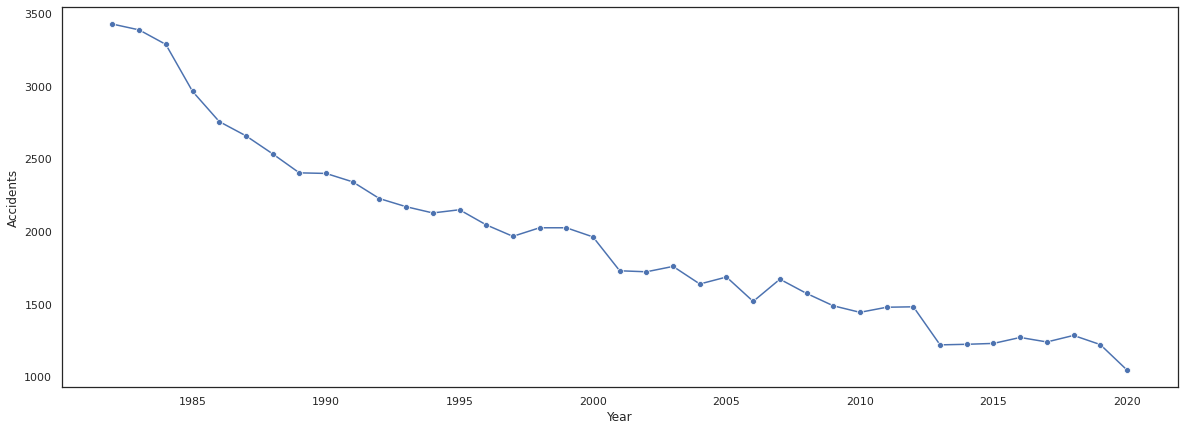

In [237]:
years = year.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
sns.lineplot(data=years, x="Year", y="Accidents",  marker="o")

* Linear Regression Classifier

In [238]:
assembler = VectorAssembler(inputCols=['Year'], outputCol='features')
year = assembler.transform(year)
year.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Accidents: integer (nullable = false)
 |-- features: vector (nullable = true)



In [239]:
train,test = year.randomSplit([0.7, 0.3])

In [240]:
# Linear Regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, labelCol="Accidents")
lrModel = lr.fit(train)

print("Intercept: {} \nCoefficient: {} \n" .format(lrModel.intercept, lrModel.coefficients.values))

modelsummary = lrModel.summary

print("R Squared (R2): {}" .format(modelsummary.r2))
print("Root Mean Squared Err: {}" .format(modelsummary.rootMeanSquaredError))
print("Mean Squared Err: {}" .format(modelsummary.meanSquaredError))
print("P-value: {}" .format(modelsummary.pValues))


Intercept: 99408.9077412486 
Coefficient: [-48.73473674] 

R Squared (R2): 0.9613968610077711
Root Mean Squared Err: 95.80722983177289
Mean Squared Err: 9179.025288038152
P-value: [0.0, 0.0]


In [241]:
pred = modelsummary.predictions
pred.show(5)

+----+---------+--------+------------------+
|Year|Accidents|features|        prediction|
+----+---------+--------+------------------+
|2020|   1048.0|[2020.0]| 964.7395300544304|
|2016|   1272.0|[2016.0]|1159.6784770072845|
|2015|   1231.0|[2015.0]|1208.4132137455017|
|2014|   1225.0|[2014.0]| 1257.147950483719|
|2013|   1221.0|[2013.0]| 1305.882687221936|
+----+---------+--------+------------------+
only showing top 5 rows



In [242]:

predictions = lrModel.transform(test)
predictions.show(5)

+----+---------+--------+------------------+
|Year|Accidents|features|        prediction|
+----+---------+--------+------------------+
|2019|     1223|[2019.0]|1013.4742667926475|
|2018|     1286|[2018.0]|1062.2090035308502|
|2017|     1241|[2017.0]|1110.9437402690673|
|2010|     1445|[2010.0]| 1452.086897436573|
|2001|     1731|[2001.0]|1890.6995280805131|
+----+---------+--------+------------------+
only showing top 5 rows



In [243]:
from pyspark.ml.evaluation import RegressionEvaluator
pred_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Accidents",metricName="r2")
print("R Squared (R2) on test data = %g" % pred_evaluator.evaluate(predictions))

R Squared (R2) on test data = 0.840313


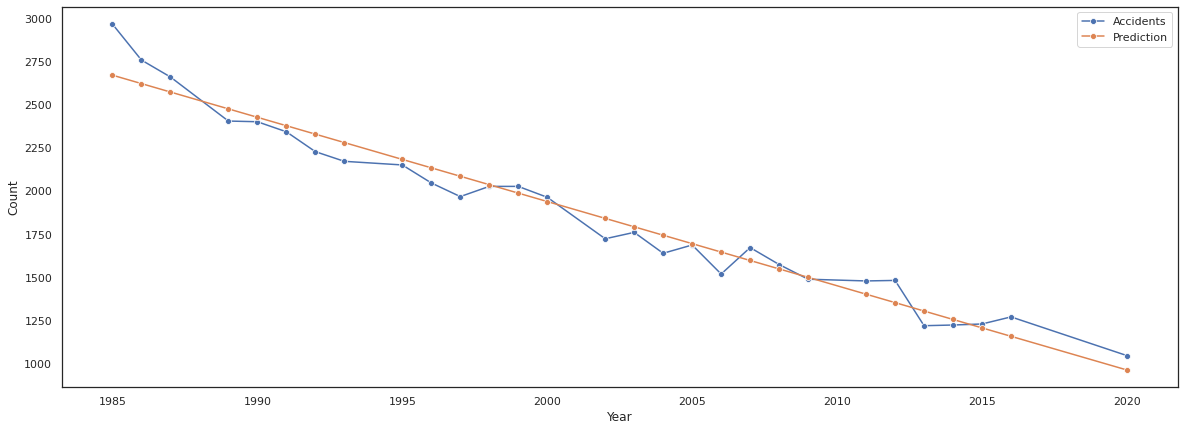

In [244]:
# pred = pred.withColumn("Year", pred["Year"].cast('string'))

prediction = pred.toPandas()

fig, ax = plt.subplots()
fig.set_size_inches(20, 7)
sns.lineplot(data=prediction, x="Year", y="Accidents",  marker="o", label = "Accidents")
sns.lineplot(data=prediction, x="Year", y="prediction",  marker="o", label = "Prediction")
plt.ylabel("Count")
plt.legend()
plt.show()

* Chi square tests

* __Investigation Type and Broad phase of light__

In [245]:
crosstab = df.crosstab("Investigation Type", "Broad phase of flight").show()

+----------------------------------------+--------+-----+------+-------+---------+-------+-----------+-----+--------+-------+----+-------+
|Investigation Type_Broad phase of flight|Approach|Climb|Cruise|Descent|Go-around|Landing|Maneuvering|Other|Standing|Takeoff|Taxi|Unknown|
+----------------------------------------+--------+-----+------+-------+---------+-------+-----------+-----+--------+-------+----+-------+
|                                Incident|     214|  169|   305|    101|       18|    345|         48|    9|      66|    324| 147|     61|
|                                Accident|    7578| 2026| 10179|   2046|     1633|  19762|      10074|  136|    1046|  15271|2054|   4041|
+----------------------------------------+--------+-----+------+-------+---------+-------+-----------+-----+--------+-------+----+-------+



Incident: 0.0

Accident:1.0

Landing:3.0

Takeoff:4.0

In [246]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest
chi_data = [(0.0, Vectors.dense(3.0)) for x in range(345)] + [(0.0, Vectors.dense(4.0)) for x in range(324)]\
        + [(1.0, Vectors.dense(3.0)) for x in range(19762)] + [(1.0, Vectors.dense(4.0)) for x in range(15271)] 
chi_df = spark.createDataFrame(chi_data, ["label", "features"])

r = ChiSquareTest.test(chi_df, "features", "label")

r.show(truncate=False)


+----------------------+----------------+-------------------+
|pValues               |degreesOfFreedom|statistics         |
+----------------------+----------------+-------------------+
|[0.012408890630137615]|[1]             |[6.251489666973616]|
+----------------------+----------------+-------------------+



__Null Hypothesis:__ The proportion of investigation type was not significantly different during landing and takeoff.

__Alternate Hypothesis:__ The proportion of investigation type was significantly different during landing and takeoff.

__Significance level:__ 0.05.


__Result:__
Chi-Square test was conducted to test whether there was significantly difference in the proportion of investigation type landing and takeoff.Result of chi-square test concludes that there was significant difference in investigation type accross landing and takeoff, p < 0.05.


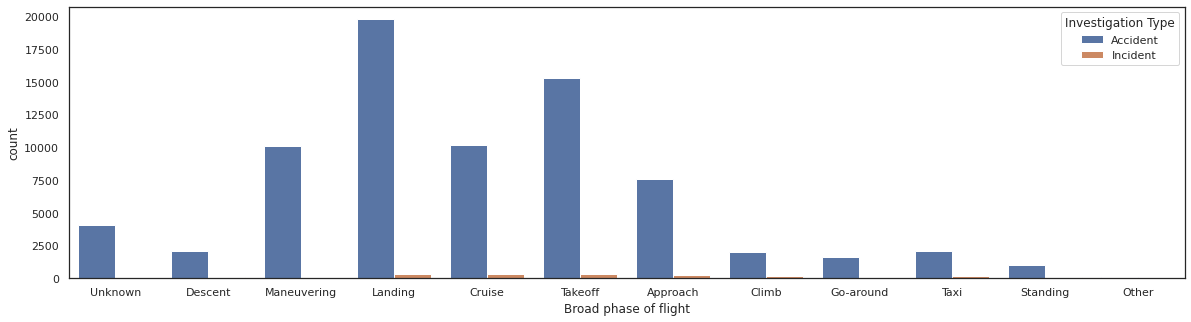

In [247]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(data["Broad phase of flight"], palette="deep", hue=data["Investigation Type"])

* __Investigation Type and Weather Condition:__

In [248]:
crosstab = df.crosstab("Investigation Type", "Weather Condition")
crosstab.show()
cs=crosstab.toPandas()



+------------------------------------+----+---+-----+
|Investigation Type_Weather Condition| IMC|UNK|  VMC|
+------------------------------------+----+---+-----+
|                            Incident| 178| 43| 1586|
|                            Accident|5034|936|69876|
+------------------------------------+----+---+-----+



Incident: 0.0

Accident:1.0

IMC:3.0

UNK:4.0

VMC:5.0

In [249]:
chi_data = [(0.0, Vectors.dense(3.0)) for x in range(178)] + [(0.0, Vectors.dense(4.0)) for x in range(43)] + [(0.0, Vectors.dense(5.0)) for x in range(1586)]\
        + [(1.0, Vectors.dense(3.0)) for x in range(5034)] + [(1.0, Vectors.dense(4.0)) for x in range(936)] +[(1.0, Vectors.dense(5.0)) for x in range(69786)]
chi_df = spark.createDataFrame(chi_data, ["label", "features"])

r = ChiSquareTest.test(chi_df, "features", "label")

r.show(truncate=False)


+------------------------+----------------+-------------------+
|pValues                 |degreesOfFreedom|statistics         |
+------------------------+----------------+-------------------+
|[2.3833490736535623E-11]|[2]             |[48.91985641158979]|
+------------------------+----------------+-------------------+



__Null Hypothesis:__ The proportion of investigation type was not significantly different across different weather.

__Alternate Hypothesis:__ The proportion of investigation type  was significantly different across different weather.

__Significance level:__ 0.05.


__Result:__
Chi-Square test was conducted to test whether there was significantly difference in the proportion of investigation type across different weather.Result of chi-square test concludes that there was significantly significant difference in investigation type across different weather, p < .001.

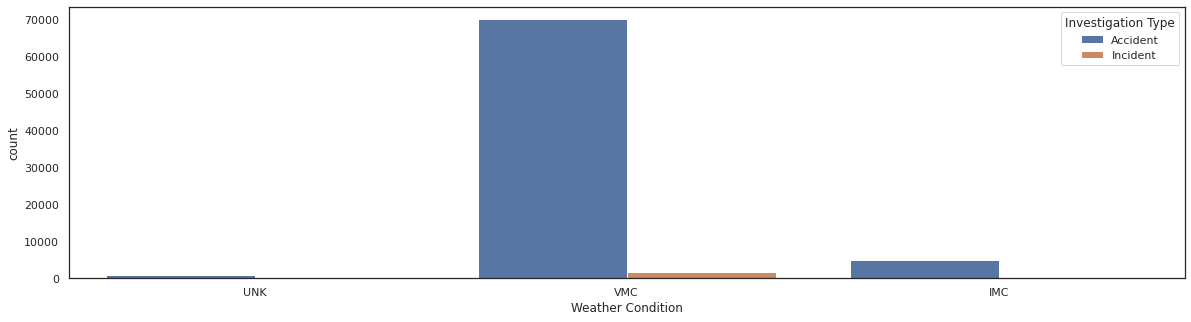

In [250]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(data["Weather Condition"], palette="deep", hue=data["Investigation Type"])

* __Investigation Type and Purpose of flight :__

In [251]:
crosstab = df.crosstab("Investigation Type", "Purpose of flight").show()

+------------------------------------+----+------------------+------------------+--------+-------------+----+----------+---+--------+-------------------+----+-------------+-----+------------+----+-----------+----+----+----------+----+-------------+--------------+----+--------+----+-----------+----+---------------+-------------------------+-----------------------+-----------------------+---------+---+-------+
|Investigation Type_Purpose of flight|Aapl|Aerial Application|Aerial Observation|Air Drop|Air Race/show|Aobv|Banner Tow|Bus|Business|Executive/corporate|Exld|External Load|Ferry|Firefighting|Firf|Flight Test|Flts|Gldt|Glider Tow|Inst|Instructional|Other Work Use|Pers|Personal|Posi|Positioning|Pubf|Public Aircraft|Public Aircraft - Federal|Public Aircraft - Local|Public Aircraft - State|Skydiving|UNK|Unknown|
+------------------------------------+----+------------------+------------------+--------+-------------+----+----------+---+--------+-------------------+----+-------------+----

[Text(0, 0, 'Instructional'),
 Text(0, 0, 'Personal'),
 Text(0, 0, 'Exld'),
 Text(0, 0, 'Aerial Observation'),
 Text(0, 0, 'Executive/corporate'),
 Text(0, 0, 'Flight Test'),
 Text(0, 0, 'Pers'),
 Text(0, 0, 'Inst'),
 Text(0, 0, 'Bus'),
 Text(0, 0, 'Business'),
 Text(0, 0, 'Aerial Application'),
 Text(0, 0, 'Positioning'),
 Text(0, 0, 'Pubf'),
 Text(0, 0, 'Posi'),
 Text(0, 0, 'Other Work Use'),
 Text(0, 0, 'Ferry'),
 Text(0, 0, 'External Load'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'Public Aircraft - Local'),
 Text(0, 0, 'Aapl'),
 Text(0, 0, 'Firefighting'),
 Text(0, 0, 'Aobv'),
 Text(0, 0, 'Banner Tow'),
 Text(0, 0, 'Glider Tow'),
 Text(0, 0, 'Skydiving'),
 Text(0, 0, 'Firf'),
 Text(0, 0, 'Public Aircraft'),
 Text(0, 0, 'Flts'),
 Text(0, 0, 'Public Aircraft - State'),
 Text(0, 0, 'UNK'),
 Text(0, 0, 'Gldt'),
 Text(0, 0, 'Air Race/show'),
 Text(0, 0, 'Public Aircraft - Federal'),
 Text(0, 0, 'Air Drop')]

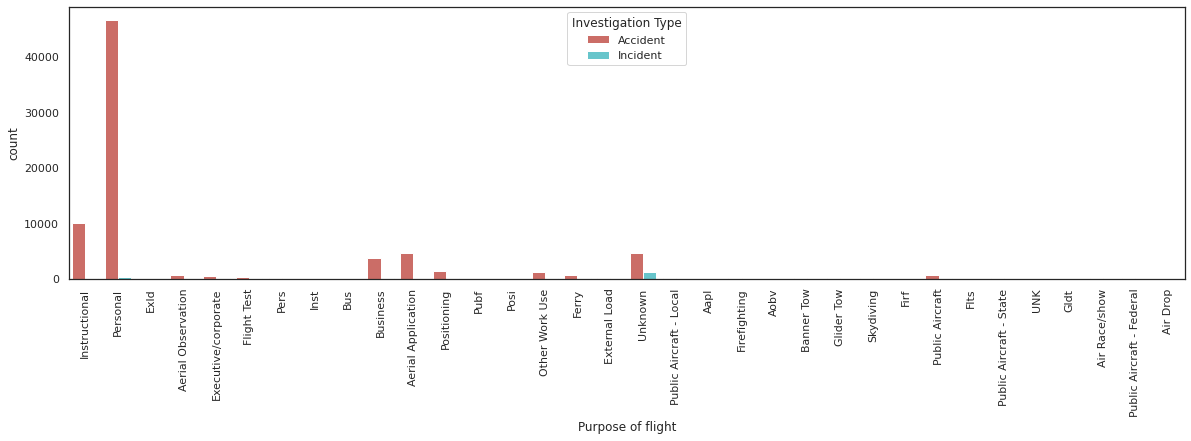

In [252]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
yr=sns.countplot(data["Purpose of flight"], palette="hls", hue=data["Investigation Type"])

yr.set_xticklabels(yr.get_xticklabels(),rotation=90)

In [253]:
def valueToCategory(value):
   if   value == "Personal":
     return "Personal"
   else: 
     return "Other"
  
from pyspark.sql.functions import udf
from pyspark.sql.types import *


udfValueToCategory = udf(valueToCategory, StringType())
df = df.withColumn("purposecategory", udfValueToCategory("Purpose of flight"))
df.show(5)

+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+---------------+
|Investigation Type|Event Date|      Country|Aircraft damage|                Make|        Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|Year|Total Injuries|purposecategory|
+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+---------------+
|          Accident|2020-12-31|United States|    Substantial|              Cessna|         172R|          

In [254]:
crosstab = df.crosstab("Investigation Type", "purposecategory").show()

+----------------------------------+-----+--------+
|Investigation Type_purposecategory|Other|Personal|
+----------------------------------+-----+--------+
|                          Incident| 1548|     259|
|                          Accident|29119|   46727|
+----------------------------------+-----+--------+



Incident: 0.0

Accident:1.0

Personal:3.0

Other:4.0

In [255]:
chi_data = [(0.0, Vectors.dense(3.0)) for x in range(1548)] + [(0.0, Vectors.dense(4.0)) for x in range(259)]\
        + [(1.0, Vectors.dense(3.0)) for x in range(29119)] + [(1.0, Vectors.dense(4.0)) for x in range(46727)]
chi_df = spark.createDataFrame(chi_data, ["label", "features"])

r = ChiSquareTest.test(chi_df, "features", "label")

r.show(truncate=False)


+-------+----------------+--------------------+
|pValues|degreesOfFreedom|statistics          |
+-------+----------------+--------------------+
|[0.0]  |[1]             |[1650.6869250031825]|
+-------+----------------+--------------------+



__Null Hypothesis:__ The proportion of investigation type was not significantly different for purpose of flight(personal and others).

__Alternate Hypothesis:__ The proportion of investigation type was significantly different for purpose of flight(personal and others).

__Significance level:__ 0.05.


__Result:__
Chi-Square test was conducted to test whether there was significantly difference in the proportion of investigation type for personal and other purpose of flight. Result of chi-square test concludes that there was significantly significant difference in investigation type for personal and other purpose of flight, p < .001.

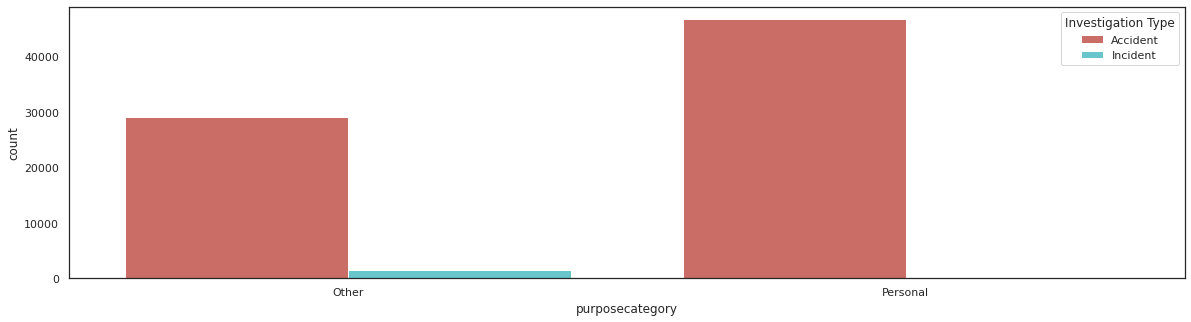

In [256]:
data =df.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
sns.countplot(data["purposecategory"], palette="hls", hue=data["Investigation Type"])

* Make analysis

In [257]:
df.groupBy("Make").count().sort('count', ascending=False).show(20)#Sorting values of Make column in descending order

+--------------+-----+
|          Make|count|
+--------------+-----+
|        Cessna|24915|
|         Piper|13696|
|         Beech| 4826|
|          Bell| 2104|
|        Mooney| 1259|
|       Grumman| 1134|
|      Bellanca| 1026|
|        Boeing| 1004|
|      Robinson|  905|
|        Hughes|  845|
|     Schweizer|  729|
|   Air Tractor|  639|
|       Aeronca|  608|
|         Maule|  555|
|      Champion|  503|
|       Stinson|  427|
|      Luscombe|  402|
|Aero Commander|  381|
|   Taylorcraft|  374|
|North American|  364|
+--------------+-----+
only showing top 20 rows



In [258]:
def get_company(company):
    
    if company in ['Cessna','Piper','Beech']:
        
        return company.upper()
    
    else:
        
        if company in ['CESSNA','PIPER','BEECH']:
            
            return company
        
        else:
            
            return 'OTHER'
            
from pyspark.sql.functions import udf
from pyspark.sql.types import *
udfVal_ToCategory = udf(get_company, StringType())
df = df.withColumn("company", udfVal_ToCategory("Make"))
df.show(5)


+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+---------------+-------+
|Investigation Type|Event Date|      Country|Aircraft damage|                Make|        Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|Year|Total Injuries|purposecategory|company|
+------------------+----------+-------------+---------------+--------------------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+---------------+-------+
|          Accident|2020-12-31|United States|    Substantial|              Cessna|

In [259]:
df_selected = df[df['company'].isin(['CESSNA','PIPER','BEECH'])]
df_selected.show(5)

+------------------+----------+-------------+---------------+------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+---------------+-------+
|Investigation Type|Event Date|      Country|Aircraft damage|  Make|        Model|Amateur Built|Engine Type|Purpose of flight|Total Fatal Injuries|Total Serious Injuries|Total Minor Injuries|Total Uninjured|Weather Condition|Broad phase of flight|Year|Total Injuries|purposecategory|company|
+------------------+----------+-------------+---------------+------+-------------+-------------+-----------+-----------------+--------------------+----------------------+--------------------+---------------+-----------------+---------------------+----+--------------+---------------+-------+
|          Accident|2020-12-31|United States|    Substantial|Cessna|         172R|           No|    Unknown|    Instructiona

* AIrcraft damage vs Make analysis

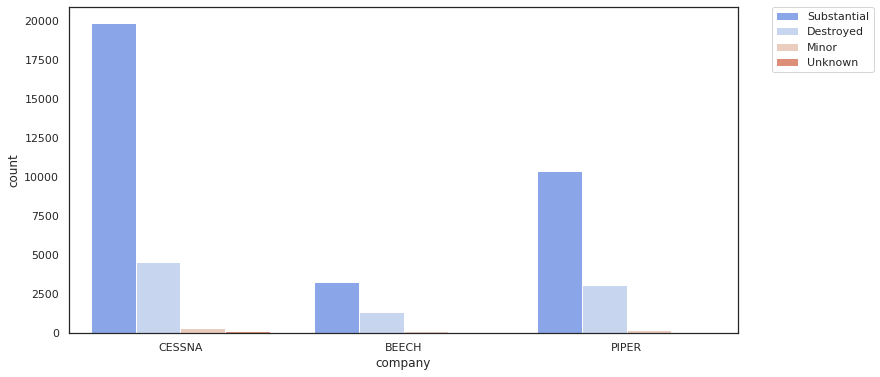

In [260]:
data = df_selected.toPandas()

plt.figure(figsize=(12,6))
sns.countplot(data['company'],hue=data['Aircraft damage'],palette='coolwarm')
plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0)

* Make vs Broad phase of filight

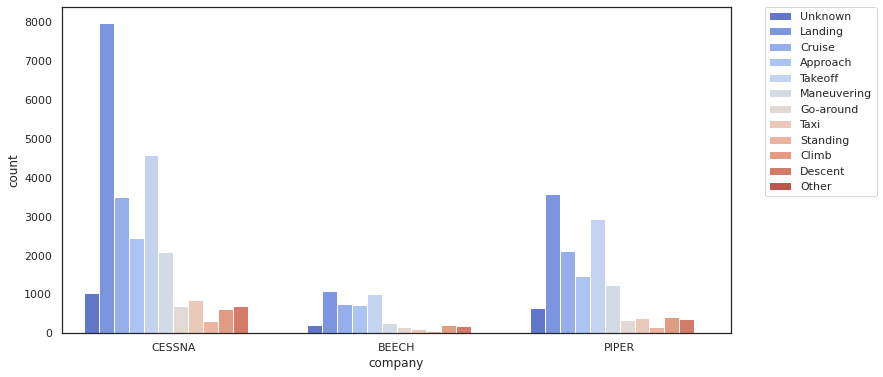

In [261]:
plt.figure(figsize=(12,6))
sns.countplot(data['company'],hue=data['Broad phase of flight'],palette='coolwarm')
plt.legend(bbox_to_anchor = (1.05,1), loc=2, borderaxespad=0)


* Box plot for company vs Total injured, and Total injuries

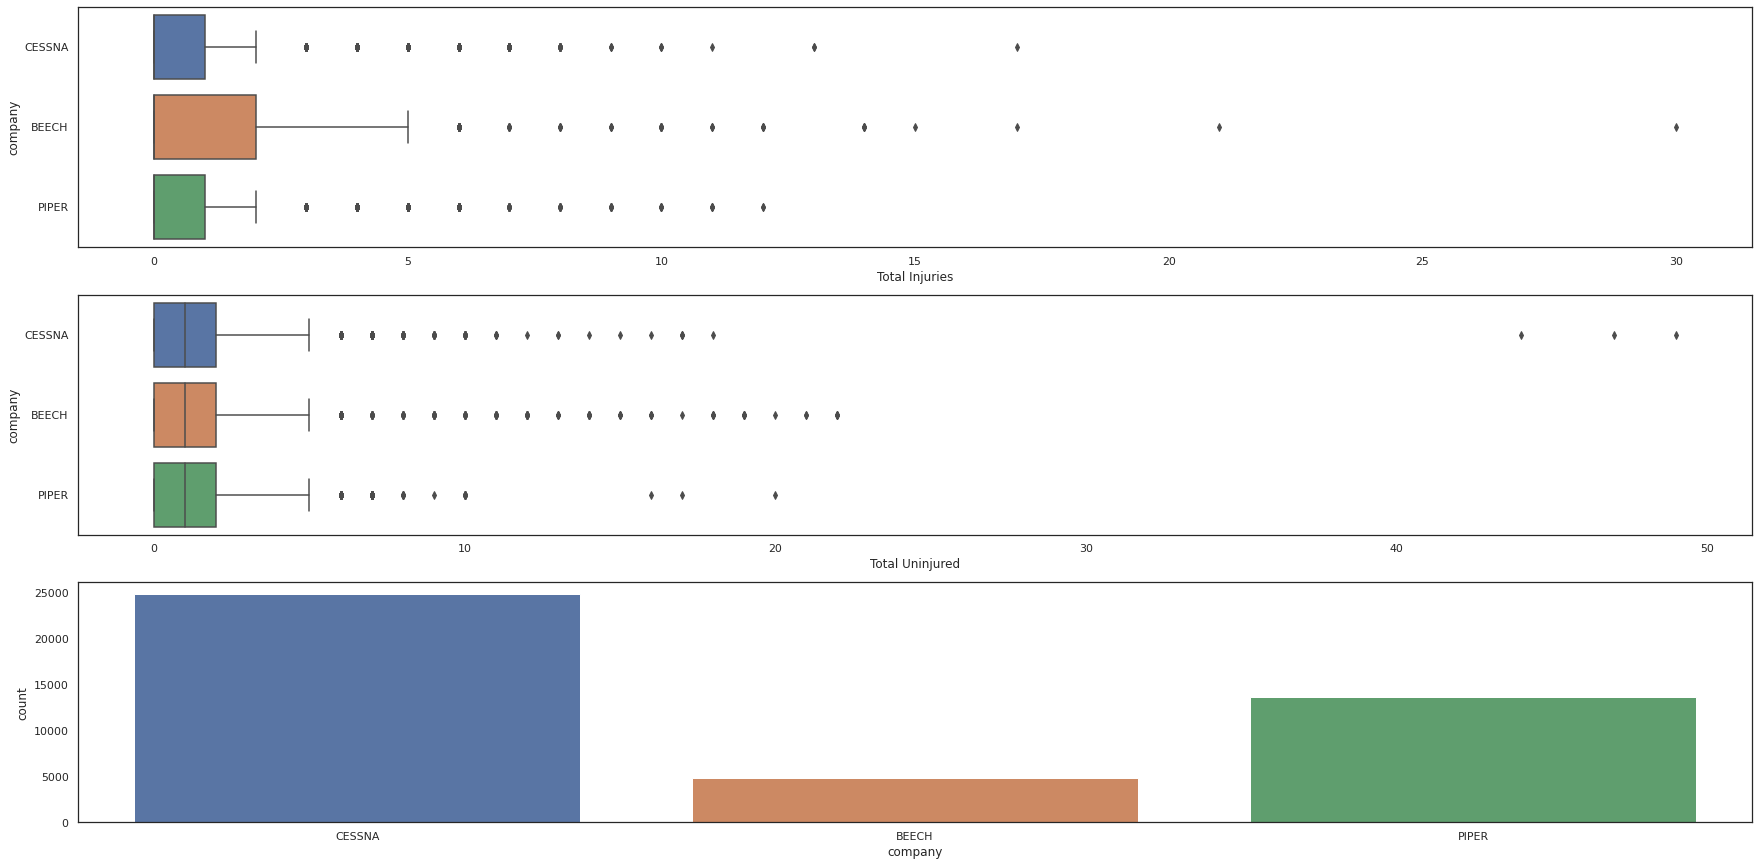

In [262]:
f,axes = plt.subplots(3,1,figsize=(30,15))
data1=data[data['Total Injuries']<= 60]
data2=data[data['Total Uninjured']<=50]
sns.boxplot(x='Total Injuries',y='company',data=data1, orient ='h',ax=axes[0])
sns.boxplot(x='Total Uninjured',y='company',data=data2,orient='h',ax=axes[1])
sns.countplot(data['company'])


* Random Forest classifier

In [263]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

cf= df.select("Aircraft Damage", "Total Injuries", "Weather Condition", "Broad phase of flight")

cols = cf.columns 

# independent variables
categoricalColumns = ["Aircraft Damage", "Weather Condition", "Broad phase of flight"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
  
# dependent variable
label_stringIdx = StringIndexer(inputCol = "Broad phase of flight", outputCol = "label")
stages += [label_stringIdx]
numericCols = ["Total Injuries"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [264]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(cf)
cf = pipelineModel.transform(cf)
selectedCols = ['label', 'features'] + cols
cf = cf.select(selectedCols)
cf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Aircraft Damage: string (nullable = false)
 |-- Total Injuries: integer (nullable = true)
 |-- Weather Condition: string (nullable = false)
 |-- Broad phase of flight: string (nullable = false)



In [265]:
cf.show(6)

+-----+--------------------+---------------+--------------+-----------------+---------------------+
|label|            features|Aircraft Damage|Total Injuries|Weather Condition|Broad phase of flight|
+-----+--------------------+---------------+--------------+-----------------+---------------------+
|  5.0|(17,[0,10],[1.0,1...|    Substantial|             0|              UNK|              Unknown|
|  5.0|(17,[0,3,10],[1.0...|    Substantial|             0|              VMC|              Unknown|
|  5.0|(17,[0,3,10],[1.0...|    Substantial|             0|              VMC|              Unknown|
|  5.0|(17,[0,3,10],[1.0...|    Substantial|             0|              VMC|              Unknown|
|  5.0|(17,[0,3,10],[1.0...|    Substantial|             0|              VMC|              Unknown|
|  5.0|(17,[0,3,10],[1.0...|    Substantial|             0|              VMC|              Unknown|
+-----+--------------------+---------------+--------------+-----------------+---------------------+


In [266]:
train, test = cf.randomSplit([0.7, 0.3])

In [267]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
# predictions.show(10)
# predictions.select("label").distinct()
predictions.groupBy("label").count().show(predictions.select("label").distinct().count())


+-----+-----+
|label|count|
+-----+-----+
|  8.0|  640|
|  0.0| 5984|
|  7.0|  694|
|  1.0| 4707|
|  4.0| 2366|
| 11.0|   44|
|  3.0| 3081|
|  2.0| 3148|
| 10.0|  333|
|  6.0|  651|
|  5.0| 1224|
|  9.0|  519|
+-----+-----+



In [268]:
 predictions.show(10)

+-----+--------------------+---------------+--------------+-----------------+---------------------+--------------------+--------------------+----------+
|label|            features|Aircraft Damage|Total Injuries|Weather Condition|Broad phase of flight|       rawPrediction|         probability|prediction|
+-----+--------------------+---------------+--------------+-----------------+---------------------+--------------------+--------------------+----------+
|  0.0|(17,[0,3,5],[1.0,...|    Substantial|             0|              VMC|              Landing|[18.4179679016095...|[0.92089839508047...|       0.0|
|  0.0|(17,[0,3,5],[1.0,...|    Substantial|             0|              VMC|              Landing|[18.4179679016095...|[0.92089839508047...|       0.0|
|  0.0|(17,[0,3,5],[1.0,...|    Substantial|             0|              VMC|              Landing|[18.4179679016095...|[0.92089839508047...|       0.0|
|  0.0|(17,[0,3,5],[1.0,...|    Substantial|             0|              VMC|     

In [269]:
summary = rfModel.summary

print("Accuracy: {:.3f}%" .format(summary.accuracy *100))
print("Precision:", summary.weightedPrecision)
print("Recall:", summary.weightedRecall)



Accuracy: 98.404%
Precision: 0.9839270041190619
Recall: 0.9840403965943018


### THE END